In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as pl
import matplotlib.pyplot as plt
import requests
import zipfile
import io 
import urllib
import seaborn as sns

import statsmodels.formula.api as smf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
%pylab inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


## Instructions

captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task
Captions need to describe: what is plotted and what is interesting about it

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.

respect coding standards
The following PEP8 rules are now required

Points will be taken off if they are violated

problem statement
An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z

Either obtain the data through the API or download the csv file, and move it to $PUIDATA

However this datasets does not have the number of units. We can find that in the Pluto dataset.

Reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# Data Wrangling 

## 1. Reading in energy data

In [2]:
!curl https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD > energy.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  3473k      0 --:--:--  0:00:01 --:--:-- 3474k


In [3]:
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/mbh329/PUIdata


In [4]:
!mv energy.csv $PUIDATA

In [5]:
energy_df = pd.read_csv('%s/energy.csv'%os.getenv("PUIDATA"))

## 2. Reading in Manhattan Pluto data 

In [6]:
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'

print("PUIdata", os.getenv("PUIDATA"))

print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")

z.extractall(path='/nfshome/mbh329/PUIdata/')

filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

PUIdata /nfshome/mbh329/PUIdata
Done
['MNMapPLUTO.dbf', 'MNMapPLUTO.prj', 'MNMapPLUTO.shp', 'MNMapPLUTO.shx', 'MN_Dcp_Mappinglot.dbf', 'MN_Dcp_Mappinglot.prj', 'MN_Dcp_Mappinglot.shp', 'MN_Dcp_Mappinglot.shx', 'mn_pluto.dbf']


In [7]:
bsize = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

# Exploring the data

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. A scatter matrix is a plot of all variables in your data against all other variables: each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


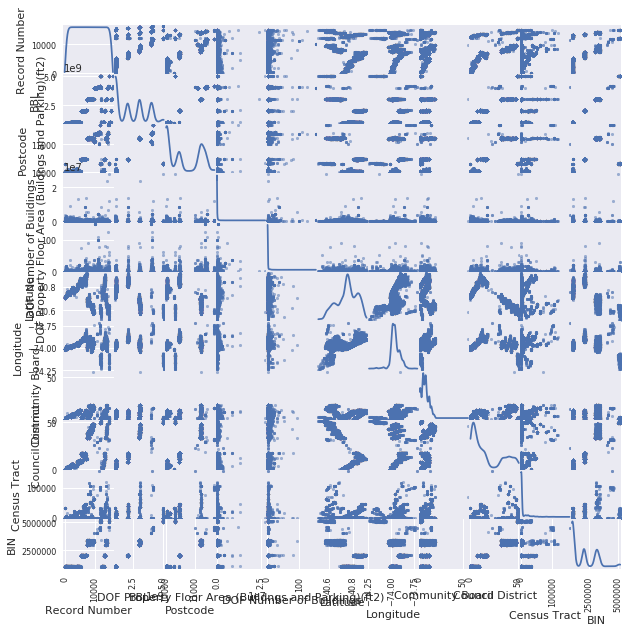

In [8]:
sfig = pd.scatter_matrix(energy_df, s=30, figsize=(10, 10), diagonal='kde')


Figure 1: ...

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

# data cleaning and aggregation

### checking the content of the datasets

clean up columns I am not using: for my solution, I will keep BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

In [9]:
## ENERGY DATA CLEANING BELOW - DNFT
energy_df.columns 

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [10]:
energy_df.drop(['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'], axis=1, inplace=True)
               
#keeping 'BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)',
# ENERGY DF 

energy_df.head(5)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [11]:
### MANHATTAN PLUTO DATA CLEANING 

bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent',
       'HealthArea', 'SanitBoro', 'SanitDistr', 'SanitSub', 'Address',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1',
       'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone',
       'BldgClass', 'LandUse', 'Easements', 'OwnerType', 'OwnerName',
       'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea',
       'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource',
       'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront',
       'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode',
       'LotType', 'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2010', 'XCo

In [12]:
bsize.drop(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent',
       'HealthArea', 'SanitBoro', 'SanitDistr', 'SanitSub', 'Address',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1',
       'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone',
       'BldgClass', 'LandUse', 'Easements', 'OwnerType', 'OwnerName',
       'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea',
       'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource',
       'NumBldgs', 'NumFloors', 'LotFront',
       'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode',
       'LotType', 'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand',
       'ExemptTot', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
        'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
       'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
       'FIRM07_FLA', 'PFIRM15_FL', 'Version', 'MAPPLUTO_F', 'SHAPE_area',
       'SHAPE_len'], axis=1, inplace=True)

bsize.head(5)
           
### Keeping 'BBL', 'UnitsRes', 'UnitsTotal','geometry', 'YearBuilt',

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


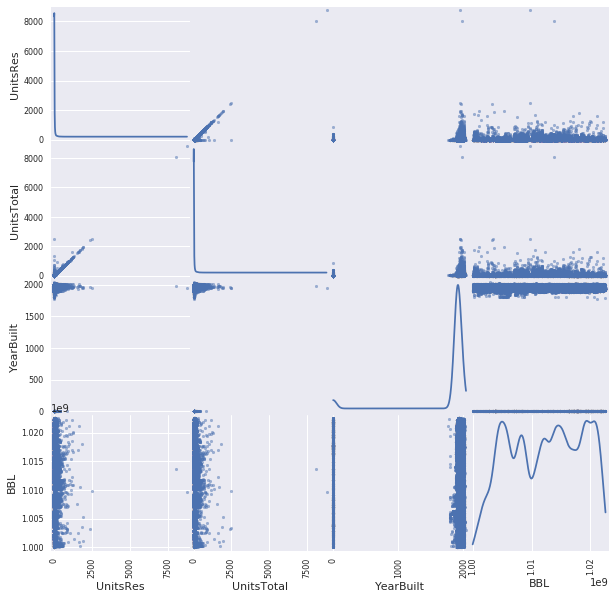

In [13]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')


Figure 2: A scatter plot matrix of the cleaned bsize dataframe consisiting of the relevant data: BBL (Borough, Block, Lot), UnitsRes (# of Units that are Residential out of total units), UnitsTotal, and YearBuilt. Within the matrix we see 4 plots (1a, 2b, 3c, 4d) that are lines meaning that the same value is plotted against each other on the x and y axis. The remaining scatter plots are what we should give the most attention to as they are scatter plots that vary depending on plots x and y variables.  

# converting the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful



In [14]:
### Energy data pd.to_numeric 

energy_df['BBL'] = pd.to_numeric(energy_df['BBL'], errors='coerce')

In [15]:
energy_df['Site EUI(kBtu/ft2)'] = pd.to_numeric(energy_df['Site EUI(kBtu/ft2)'], errors='coerce')

energy_df['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(\
     energy_df['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

In [16]:
bsize['BBL'] = pd.to_numeric(bsize['BBL'], errors='coerce')

In [17]:
##check that your conversion worked: e.g.
energy_df['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [18]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:",\
       np.isnan(energy_df['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [19]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(energy_df['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(energy_df['Site EUI(kBtu/ft2)'])))


fraction of missing energy observations: 0.29


# Merge the 2 dfs

In [20]:
bblnrgdataGPD = bsize.merge(energy_df, on='BBL') #GeoDataframe used for mapping 
bblnrgdata = bsize.merge(energy_df, on='BBL').drop('geometry', axis=1)

#merge in a geodataframe for mapping + if you want in a regular DF for analysis (more portable)







In [21]:
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,68.7,95844.0
1,29,32,1928,1.013850e+09,87.4,206989.0
2,72,72,1923,1.021740e+09,140.4,52920.0
3,107,108,1931,1.008830e+09,96.5,98359.0
4,134,138,1910,1.008570e+09,36.4,154000.0


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [22]:
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['UnitsTotal']+1)
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)']+1)

bblnrgdataGPD.head(5)


,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logarea,lognrg
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,1.707570,1.843233
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,1.518514,1.946452
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0,1.863323,2.150449
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0,2.037426,1.989005
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0,2.143015,1.572872


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


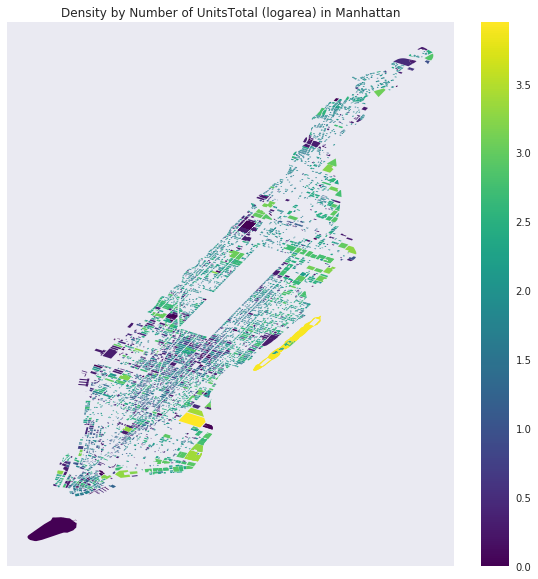

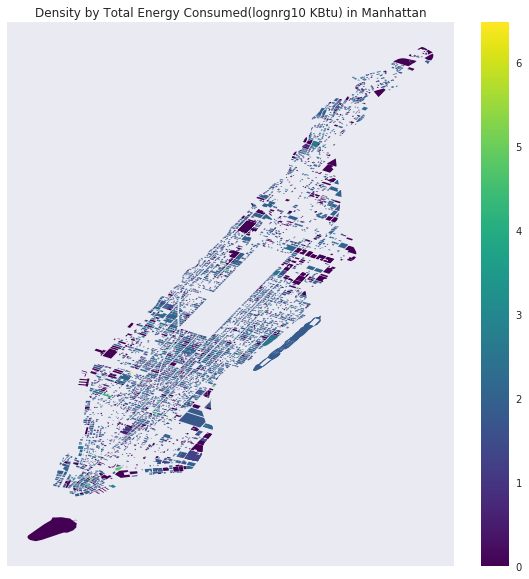

In [23]:
f, ax = plt.subplots(figsize=(10,10))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bblnrgdataGPD.plot(column='logarea',cmap='viridis',alpha=1,legend=True, ax=ax)
                  
plt.title("Density by Number of UnitsTotal (logarea) in Manhattan");


f, ax = plt.subplots(figsize=(10,10))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bblnrgdataGPD.plot(column='lognrg',cmap='viridis',alpha=1,legend=True, ax=ax)
plt.title("Density by Total Energy Consumed(lognrg10 KBtu) in Manhattan");

#k=10linewidth=0.1,ax=ax, scheme="quantiles", linewidth=0.1,ax=ax, scheme="quantiles", legend=True, k=10

Figure 2: I created a new merged GDF and then added two new columns ((logarea= log10(Unitstotal +1) and lognrg = log10(Site EUI(kBtu/ft2)) to highlight the data better as the differences in unit data are minimal. I plotted the two individual columns in a chloropleth map that highlights both columns. The first figure shows us that the areas in yellow have higher # of concentration of units per building (see Roosevelt Island which has a high concentration of units per building) while the second map shows us that there is not a lot of difference in energy consumption across the borough of Manhattan. This might be a matter of scale as the unit of measurement might be quite large to measure across energy consumption or it could be an inadaquacy of my map itself.  

## feature engineering

the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model total energy with total units. Create a total energy column from the columns you have. Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [24]:
## multiplying area by energy/area to get total energy per building



bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']\
            .astype(float) * bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

In [25]:
bblnrgdata.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg
count,6438.000000,6438.000000,6438.000000,6.438000e+03,5.047000e+03,5.545000e+03,5.039000e+03
mean,97.137776,109.339546,1931.534793,1.012057e+09,1.155594e+03,2.133406e+05,2.132715e+08
std,247.860997,250.111307,152.294367,5.667368e+06,4.284263e+04,3.242996e+05,5.260042e+09
min,0.000000,0.000000,0.000000,1.000010e+09,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,19.000000,1920.000000,1.008190e+09,NaN,NaN,NaN
50%,49.000000,59.500000,1930.000000,1.012360e+09,NaN,NaN,NaN
75%,107.000000,117.000000,1965.000000,1.015478e+09,NaN,NaN,NaN
max,8764.000000,8812.000000,2017.000000,1.022500e+09,3.018493e+06,9.515627e+06,3.501452e+11


In [26]:
bblnrgdata = bblnrgdata[bblnrgdata['UnitsTotal'] <8000]
bblnrgdata = bblnrgdata[bblnrgdata['nrg'] <3.5e11]

#set range of values as defined by bianco, this is a function same gave me. 

In [27]:
bblnrgdata['logunits'] = np.log10(bblnrgdata['UnitsTotal']+1)
bblnrgdata['lognrg'] = np.log10(bblnrgdata['nrg']+1)


In [28]:
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logunits,lognrg
0,50,50,1914,1.007238e+09,68.7,95844.0,6584482.8,1.707570,6.818522
1,29,32,1928,1.013850e+09,87.4,206989.0,18090838.6,1.518514,7.257459
2,72,72,1923,1.021740e+09,140.4,52920.0,7429968.0,1.863323,6.870987
3,107,108,1931,1.008830e+09,96.5,98359.0,9491643.5,2.037426,6.977341
4,134,138,1910,1.008570e+09,36.4,154000.0,5605600.0,2.143015,6.748622


## Plot Scatter

In [29]:
bblnrgdata.describe()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logunits,lognrg
count,5035.000000,5035.000000,5035.000000,5.035000e+03,5035.000000,5.035000e+03,5.035000e+03,5035.000000,5035.000000
mean,95.116981,107.781529,1935.033962,1.012012e+09,558.669593,2.123788e+05,1.437710e+08,1.696481,7.049414
std,161.040232,163.999837,132.093622,5.515258e+06,5562.441346,2.970382e+05,1.833059e+09,0.631503,0.579475
min,0.000000,0.000000,0.000000,1.000048e+09,0.000000,1.000000e+03,0.000000e+00,0.000000,0.000000
25%,0.000000,27.000000,1920.000000,1.008265e+09,65.900000,7.203400e+04,5.861188e+06,1.447158,6.767986
50%,55.000000,63.000000,1930.000000,1.012370e+09,83.000000,1.159500e+05,9.337911e+06,1.806180,6.970250
75%,113.000000,123.000000,1965.000000,1.015150e+09,104.100000,2.198650e+05,1.896025e+07,2.093422,7.277844
max,2491.000000,2498.000000,2016.000000,1.022500e+09,119619.800000,5.207812e+06,6.779388e+10,3.397766,10.831190


Text(0.5,1,'Does # of occupancies increase energy consumption? Scatter plot of Energy Consumed vs Units Total ')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


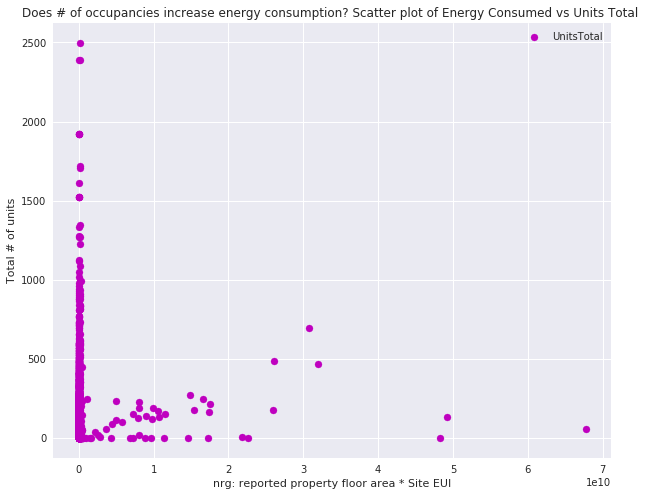

In [30]:
#here i am plotting with plt

pl.figure(figsize=(10, 8))

plt.scatter(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'], c='m')

#how do i get it on the xaxis???
#Yavuz helped me with this sci not., if you change the value of sci not. then your scale changes
#xlim(0, 0.5)
#ylim(0,2000)
plt.xlabel('nrg: reported property floor area * Site EUI')
plt.ylabel('Total # of units')
pl.legend()
plt.title('Does # of occupancies increase energy consumption? \
Scatter plot of Energy Consumed vs Units Total ')

Figure 4: In this figure, we have plotted the total energy consumed(nrg) on the x axis & total # of units on the Y axis because in this case we are looking at how energy consumed is influenced by the # of units in a building. The data is normally distributed as the energy consumed increased, the total # of units generally increases. There are some interesting outliers espceially those have very low energy consumption but very high total unit #. This might be because they are underreporting their overall consumption.  

## The magic of log scales!

Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year.

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the order of magnitude)

Text(0,0.5,'$log_{10}$(x)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


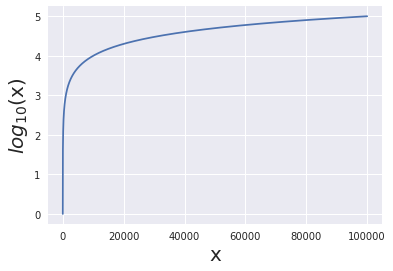

In [31]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale.

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

log_10(x^y) = y ∙ log_10(x)

And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything:

energy between (1000,1e10)

units between (1,1000)

You can cut the axis to visualize the data like this, but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.

to visualize the data in log scale you can use the dataframe plotting method with the argument

loglog=True

In [32]:
#here i am plotting with ax, this is an alt to plt and i am not sure which is better???

#fig = pl.figure(figsize=(10, 8))
#ax = fig.add_subplot()
#ax.scatter(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'])

#xlim(1000, 1e8)
#ylim(0,1000)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_xlabel('nrg')
#ax.set_ylabel('Total # of units')
#ax.legend()
#ax.set_title('B')

Text(0.5,1,'Logunits vs lognrg')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


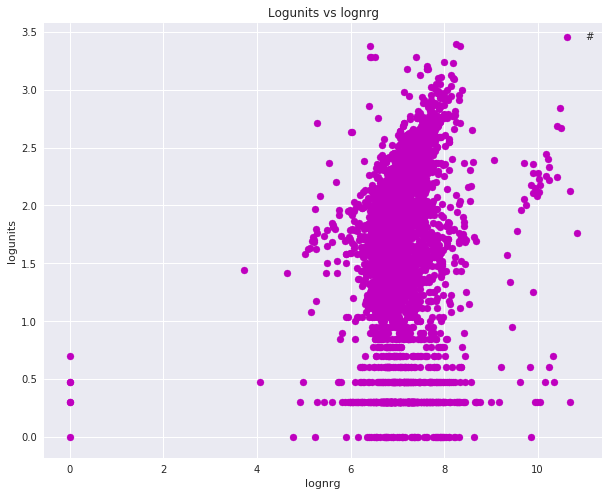

In [33]:
pl.figure(figsize=(10, 8))

plt.scatter(bblnrgdata['lognrg'],bblnrgdata['logunits'], c='m')

#Yavuz helped me with this sci not., if you change the value of sci not. then your scale changes
#xlim(1000, 1e10)
#ylim(1,1000)
plt.xlabel('lognrg')
plt.ylabel('logunits')
pl.legend('# of units')
plt.title('Logunits vs lognrg')

Figure: In this figure we have lognrg(x) plotted against the logunits(y). It shows 0 values which haven't been filtered out yet which skews the data to the right. From this we can eyeball that  a curvlinear model might be the best fit for this data.  

Text(0.5,1,'Logunits(x) vs lognrg(y)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


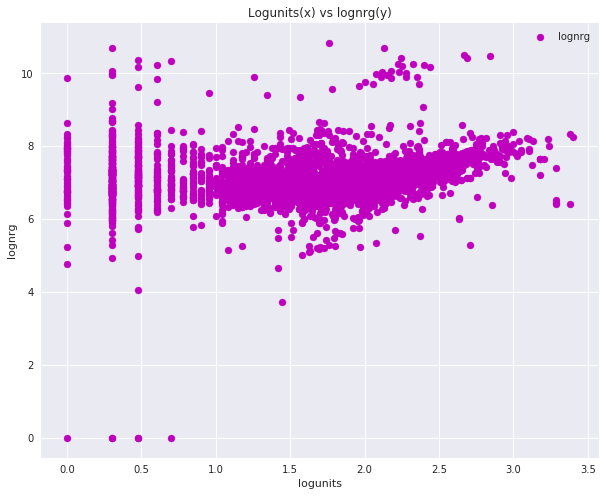

In [34]:
pl.figure(figsize=(10, 8))

plt.scatter(bblnrgdata['logunits'],bblnrgdata['lognrg'], c='m')

#Yavuz helped me with this sci not., if you change the value of sci not. then your scale changes
#xlim(1000, 1e10)
#ylim(1,1000)
plt.xlabel('logunits')
plt.ylabel('lognrg')
pl.legend()
plt.title('Logunits(x) vs lognrg(y)')

Figure 7: In this figure we see a scatter plot of logunits(x) and lognrg(y). again the data has not been cleaned fully and our data is skewed by the outliers.

## Fit the data with a line in log space:
make sure you print the summary and plot the data and the model

In [35]:
bblnrgclip = bblnrgdata.loc[(bblnrgdata.nrg > 1000) & (bblnrgdata.nrg < 1e10) & (bblnrgdata.UnitsTotal > 1) &\
                                                                    (bblnrgdata.UnitsTotal < 1000),:]


In [36]:
OLS1 = smf.ols(formula='lognrg ~ logunits', data=bblnrgclip).fit()
OLS1.summary()

#OLS=smf.ols(formula='y = bx', data=bblnrgdata).fit()
#OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     296.7
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           1.69e-64
Time:                        23:33:41   Log-Likelihood:                -2839.5
No. Observations:                4624   AIC:                             5683.
Df Residuals:                    4622   BIC:                             5696.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.6192      0.025    265.249      0.000         6.570     6.668
logunits       0.2301      0.013     17.226      0.000         0.204     0.256
==============================================================================
Omnibus:                     1322.016   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12777.957
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                      10.851   Cond. No.                         9.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'logunits(x) vs lognrg(y) - line fit of the data')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


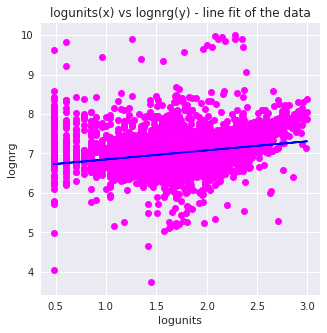

In [37]:
pl.figure(figsize=(5,5))
pl.plot(bblnrgclip['logunits'],bblnrgclip['lognrg'],'go', color='magenta')
pl.plot(bblnrgclip['logunits'], OLS1.predict(bblnrgclip),'-', color='blue')
pl.xlabel('logunits')
pl.ylabel('lognrg')
pl.title('logunits(x) vs lognrg(y) - line fit of the data')

Figure: This linear fit seems to be a decent fit of the model when logunits are plotted on the x and lognrg is ploted along the y. I suspect that the polynomial might be a btter fit based on the shape of the data. 

# Model NRG as a linear function of number of units in the building
Ciertainly there is a right way to think about this: which is the independent and the dependent variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

# ANSWER

 the the independent variable in this case is the number of units in a building and the dependent variable is the energy consumed. The number of units does not  cause energy consumption but the people in the unit cause energy consumption which is a subset of a the unit in this case. I suppose if you had a large building with many units that werent full there would be no relation with the amount of energy the building consumed but it would affect the potential energy the building could consume. The more units a building has the more potential the building has to consume energy. If you look at it from the models the totalunit as the independent variable is a better fit to the data.

## However, indulge me and try both models: models (nrg vs units total & units total vs nrg).

create the models with statsmodels
print the model summary
plot the data and the fit
Check and comment on how the following model diagnostics change:
  R^2 and LogLikelihood
(remember to use only the data in the appropriate range, see the previous step)

In [38]:
OLS2 = smf.ols(formula='logunits ~ lognrg', data=bblnrgclip).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     296.7
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           1.69e-64
Time:                        23:33:41   Log-Likelihood:                -3141.3
No. Observations:                4624   AIC:                             6287.
Df Residuals:                    4622   BIC:                             6300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0420      0.107     -0.391      0.696        -0.252     0.168
lognrg         0.2622      0.015     17.226      0.000         0.232     0.292
==============================================================================
Omnibus:                      637.872   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              982.187
Skew:                          -0.977   Prob(JB):                    5.26e-214
Kurtosis:                       4.133   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'lognrg(x) vs logunits(y) - line fit of the data')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


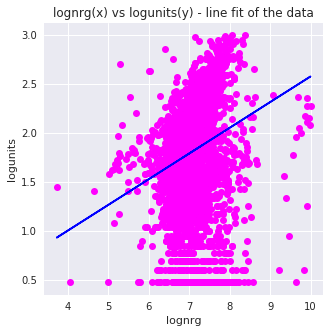

In [39]:
pl.figure(figsize=(5,5))
pl.plot(bblnrgclip['lognrg'],bblnrgclip['logunits'],'go', color='magenta')
pl.plot(bblnrgclip['lognrg'], OLS2.predict(bblnrgclip),'-', color='blue')
pl.xlabel('lognrg')
pl.ylabel('logunits')
pl.title('lognrg(x) vs logunits(y) - line fit of the data')

### OLS DATA COMPARISON: 
the two models have the same rsquared value meaning they have the same relationship to their regression. however, the log liklihood differs in th models: the first model (logunit(x) vs lognrg(y) has a log liklihood closer to 1 which means it is a better fit to the data.

# Second degree polynomial fit

model the data with a slightly more complex model:

y = ax*x + bx + c, 

instead of

y = bx + c


In [40]:
#df['x2']=df['x']**2 ~ assignment 1 

bblnrgclip['logunits2'] = bblnrgclip['logunits']**2
bblnrgclip=bblnrgclip.sort(columns='logunits')



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [41]:
bblnrgclip.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logunits,lognrg,logunits2
1567,0,2,1964,1.006170e+09,0.6,160000.0,96000.0,0.477121,4.982276,0.227645
1930,0,2,1921,1.006930e+09,18.2,89628.0,1631229.6,0.477121,6.212515,0.227645
4116,0,2,1992,1.016040e+09,371.1,745000.0,276469500.0,0.477121,8.441647,0.227645
4118,0,2,1998,1.017730e+09,303.5,55784.0,16930444.0,0.477121,7.228668,0.227645
1951,0,2,1997,1.000160e+09,134.2,58535.0,7855397.0,0.477121,6.895168,0.227645


In [42]:
OLS3 = smf.ols(formula='lognrg ~ logunits2 + logunits', data=bblnrgclip).fit()
OLS3.summary()

#here you are fit for a polynomial function, so logunits is squared (ax^2 = bx) ie quadratic eq

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     584.5
Date:                Wed, 28 Nov 2018   Prob (F-statistic):          5.08e-227
Time:                        23:33:41   Log-Likelihood:                -2462.0
No. Observations:                4624   AIC:                             4930.
Df Residuals:                    4621   BIC:                             4949.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.8501      0.049    160.996      0.000         7.755     7.946
logunits2      0.4897      0.017     28.630      0.000         0.456     0.523
logunits      -1.4014      0.058    -24.038      0.000        -1.516    -1.287
==============================================================================
Omnibus:                     1445.166   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24558.132
Skew:                           1.040   Prob(JB):                         0.00
Kurtosis:                      14.097   Cond. No.                         55.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Energy Consumption by # of total Units in a Building')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


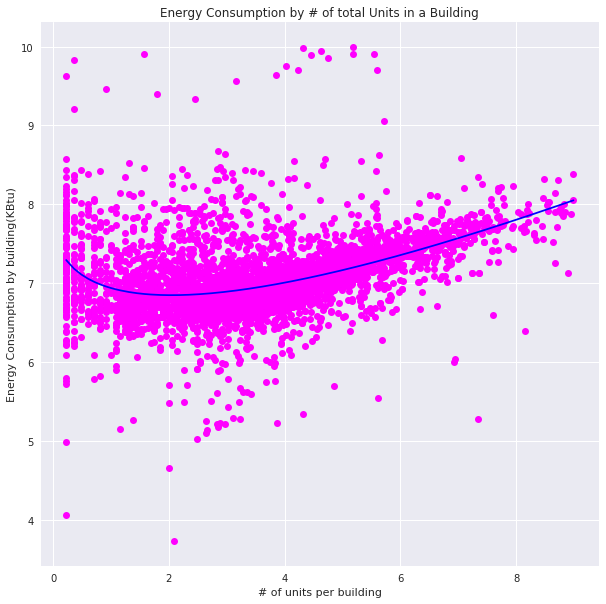

In [43]:
pl.figure(figsize=(10,10))
pl.plot(bblnrgclip['logunits2'],bblnrgclip['lognrg'],'go', color='magenta')
pl.plot(bblnrgclip['logunits2'], OLS3.predict(bblnrgclip),'-', color='blue')
pl.xlabel('# of units per building')
pl.ylabel('Energy Consumption by building(KBtu)')
pl.title('Energy Consumption by # of total Units in a Building')

figure: In this figure we see that the best possible fit for the line is obviously wrong as ive 

# calculate the chi square and likelihood of your model

Define a chisquare function

In [44]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        calc = np.sum((model - data)**2/errors**2)
        return(calc)

### Sam helped me with this loop for defining chisq, I would have never been able to do it without him

## Define and calculate errors


Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your dependent variable) , so the errors combine in quadrature!

Total Error = sqrt(error1^2 + error2^2)

Your independent variable has uncertainty also! assume it is also Poissonian

propagation of errors on the log: https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations









## Assume that there is error in the reported energy. 

In [45]:
bblnrgclip.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logunits,lognrg,logunits2
1567,0,2,1964,1.006170e+09,0.6,160000.0,96000.0,0.477121,4.982276,0.227645
1930,0,2,1921,1.006930e+09,18.2,89628.0,1631229.6,0.477121,6.212515,0.227645
4116,0,2,1992,1.016040e+09,371.1,745000.0,276469500.0,0.477121,8.441647,0.227645
4118,0,2,1998,1.017730e+09,303.5,55784.0,16930444.0,0.477121,7.228668,0.227645
1951,0,2,1997,1.000160e+09,134.2,58535.0,7855397.0,0.477121,6.895168,0.227645


In [51]:

## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
bblnrgclip['errorsnrg'] = np.sqrt(bblnrgclip['Site EUI(kBtu/ft2)']**2 + \
                                     bblnrgclip['Reported Property Floor Area (Building(s)) (ft²)']**2)

# THIS IS A piece of code that i got from Pmandiola. I would have no idea how to do this without him.

#Why are we calculating the errors this way? Why the sqrt?

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblnrgclip['errorsunits'] = np.sqrt(bblnrgclip['UnitsTotal'])

# Make 3 plots: one with x errors, one with y errors, one with x and y errors.
with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logunits,lognrg,logunits2,errorsunits,errorsnrg
423,461,461,1950,1.003620e+09,31.1,5207812.0,161962953.2,2.664642,8.209416,7.100317,21.470911,5.207812e+06


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


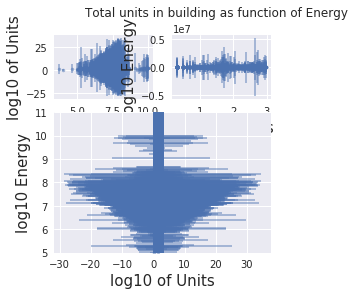

In [52]:
#fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

#gs1 = gridspec.GridSpec(3, 3, figure=fig2)
#gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgclip.nrg), np.log10(bblnrgclip.UnitsTotal), 
            yerr=bblnrgclip.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgclip.UnitsTotal), np.log10(bblnrgclip.nrg), 
            yerr=bblnrgclip.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgclip.UnitsTotal), np.log10(bblnrgclip.nrg), 
            yerr=bblnrgclip.errorsnrg,
           xerr=bblnrgclip.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgclip[bblnrgclip.errorsnrg == bblnrgclip.errorsnrg.max()]

##This is all copied directly form the skeleton NB on Fbiancos github

Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see, and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it.

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved.

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

# Add the errors and calculate the chi square
# calculate the degrees of freedom of this model

In [54]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(bblnrgclip) - smf.param.count()
print ("degrees of freedom:" , dof)

AttributeError: module 'statsmodels.formula.api' has no attribute 'param'

In [ ]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgclip.UnitsTotal), linmodel_0.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgclip.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgclip.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgclip.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgclip.errorsnrg**2 + 
                             bblnrgclip.errorsunits**2))  / dof))

In [ ]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))

Compare the models using the chi square:
 
discuss

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high leverage are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit.

Figure 10: ...


Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance 
The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models

The difference in the number of degrees of freedom is 1, so the LR statistics will follow a  distribution with 1 DOF.

LR = ... reject / not reject...